In [1]:
import os
import joblib
from datetime import datetime
from dotenv import load_dotenv

import matplotlib.pyplot as plt
import mlflow
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from catboost import CatBoostClassifier, Pool
from implicit.cpu.als import AlternatingLeastSquares
from pandas.errors import MergeError
from sklearn.preprocessing import LabelEncoder

load_dotenv()

sns.set_theme()

In [2]:
DATA = "../data"
REC_DATA = "../fastapi_service/recommendations"
POSTGRES_DATA= "../airflow_service/postgres_data"
ASSETS = "./assets"
RANDOM_STATE = 123


EXPERIMENT_NAME = "RECSYS_EXP"
TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000

In [3]:
# ASSETS - папка для записи артефактов из ML-flow
# REC_DATA - тут будут лежать таблицы с рекомендациями и использоваться в сервисе fastapi
# POSTGRES_DATA - тут таблицы с рекомендациями, которые затем будут использоваться в дагах Airflow в airflow_service.

In [4]:
if not os.path.exists(ASSETS):
    os.mkdir(ASSETS)
    
if not os.path.exists(REC_DATA):
    os.mkdir(REC_DATA)

if not os.path.exists(POSTGRES_DATA):
    os.mkdir(POSTGRES_DATA)

# MLFLOW

- В данном ноутбуке все эксперименты будут логгироваться с помощью mlflow
- На данном этапе нужно запутить mlflow как отдельный сервис:
    - Выполните команду: `sh recsys/run_mlflow.sh`
- Сервис будет доступен по локалхосту и порту 5000 

In [5]:
os.environ["MLFLOW_S3_ENDPOINT_URL"] = "https://storage.yandexcloud.net"
os.environ["AWS_ACCESS_KEY_ID"] = os.getenv("AWS_ACCESS_KEY_ID")
os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv("AWS_SECRET_ACCESS_KEY")

mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")

In [6]:
# Создадим эксперимент

In [7]:
experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
if not experiment:
    experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)
else:
    experiment_id = experiment.experiment_id

In [8]:
experiment_id

'1'

# 1. Загрузка исходных данных

In [9]:
category_tree = pd.read_csv(f"{DATA}/category_tree.csv")
events = pd.read_csv(f"{DATA}/events.csv")
item_props_1 = pd.read_csv(f"{DATA}/item_properties_part1.csv")
item_props_2 = pd.read_csv(f"{DATA}/item_properties_part2.csv")

# 2. Исследование данных

### 2.1. category_tree

In [10]:
category_tree.head()

,categoryid,parentid
0,1016,213.0
1,809,169.0
2,570,9.0
3,1691,885.0
4,536,1691.0


In [11]:
category_tree.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1669 entries, 0 to 1668
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   categoryid  1669 non-null   int64  
 1   parentid    1644 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 26.2 KB


таблица из двух столбцов: «родительская категория» и «дочерняя категория». Типичный способ представления таблицы в виде дерева.

In [12]:
# посомтрим на любую родительскую категорию
random_parentid = category_tree.sample(1)['parentid'].values[0]
category_tree[category_tree['parentid'] == random_parentid]

,categoryid,parentid
292,1083,594.0
703,686,594.0
1098,1493,594.0
1099,960,594.0


In [13]:
cat_ids_unique = category_tree.categoryid.nunique()
par_ids_unique = category_tree.parentid.nunique()

print("Количество уникальных категорий: ", cat_ids_unique)
print("Количество уникальных родительских категорий: ", par_ids_unique)

Количество уникальных категорий:  1669
Количество уникальных родительских категорий:  362


In [14]:
category_tree.isnull().sum()

categoryid     0
parentid      25
dtype: int64

Некоторые категории не имеют родительских категорий, что может означать, что такие категории являются самими группами и, следовательно, не имеют более высокой классификации.

In [15]:
category_tree[category_tree.parentid.isnull()]

,categoryid,parentid
5,231,NaN
589,791,NaN
861,1490,NaN
939,431,NaN
1111,755,NaN
1142,378,NaN
1208,1579,NaN
1211,1394,NaN
1322,659,NaN
1329,1057,NaN


In [16]:
# еще посомтрим на топ 10 самых частотных категорий

In [17]:
category_tree \
            .groupby("parentid") \
            .agg({"categoryid": "count"}) \
            .sort_values(by="categoryid", ascending=False) \
            .reset_index() \
            .head(10)

,parentid,categoryid
0,250.0,31
1,1009.0,22
2,362.0,22
3,351.0,19
4,1259.0,18
5,1687.0,17
6,945.0,15
7,312.0,15
8,92.0,13
9,1482.0,13


### 2.2. events

events.csv — таблица с логом событий:
- timestamp — временная метка события,
- visitorid — идентификатор пользователя,
- event — событие (просмотр, добавление в корзину, покупка),
- itemid — идентификатор товара,
- transactionid — идентификатор транзакции (покупки).

In [18]:
events.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2756101 entries, 0 to 2756100
Data columns (total 5 columns):
 #   Column         Dtype  
---  ------         -----  
 0   timestamp      int64  
 1   visitorid      int64  
 2   event          object 
 3   itemid         int64  
 4   transactionid  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 244.9 MB


In [19]:
events.sample(10)

,timestamp,visitorid,event,itemid,transactionid
1429401,1442327725934,173863,view,389088,NaN
1530076,1430965411084,356490,view,123636,NaN
2421824,1437177437566,635017,view,230207,NaN
1155638,1441081700272,946197,view,22223,NaN
2092573,1435849354136,1202783,view,393511,NaN
299357,1434308051658,110035,view,53898,NaN
495911,1435246376638,723804,view,244871,NaN
1895852,1432406060699,938134,view,384319,NaN
1400402,1442203721319,1079989,view,423162,NaN
2137542,1436152492991,473486,view,332080,NaN


In [20]:
print(f"История насчитывает {events.shape[0]} событий пользователей")

История насчитывает 2756101 событий пользователей


In [21]:
# Посмотрим пример

In [22]:
random_visitor = events.sample(1)['visitorid'].values[0]
events[events['visitorid'] == random_visitor]

,timestamp,visitorid,event,itemid,transactionid
664356,1438727869018,861299,view,269940,NaN
664410,1438730178358,861299,view,360922,NaN
664537,1438727967552,861299,view,239538,NaN
664606,1438722085310,861299,view,16789,NaN
664677,1438720685254,861299,view,180684,NaN
...,...,...,...,...,...
2755349,1438379878779,861299,transaction,456602,3643.0
2755390,1438379771868,861299,view,313230,NaN
2755392,1438380430262,861299,view,441852,NaN
2755552,1438356834160,861299,addtocart,411482,NaN


In [23]:
# посмотрим какие ивенты вообще есть

In [24]:
events['event'].value_counts(0.1)

event
view           0.966696
addtocart      0.025156
transaction    0.008148
Name: proportion, dtype: float64

In [25]:
# посмотрим транзакции

In [26]:
events[~events.transactionid.isna()]

,timestamp,visitorid,event,itemid,transactionid
130,1433222276276,599528,transaction,356475,4000.0
304,1433193500981,121688,transaction,15335,11117.0
418,1433193915008,552148,transaction,81345,5444.0
814,1433176736375,102019,transaction,150318,13556.0
843,1433174518180,189384,transaction,310791,7244.0
...,...,...,...,...,...
2755294,1438377176570,1050575,transaction,31640,8354.0
2755349,1438379878779,861299,transaction,456602,3643.0
2755508,1438357730123,855941,transaction,235771,4385.0
2755603,1438355560300,548772,transaction,29167,13872.0


In [27]:
events[events['visitorid'] == 599528]

,timestamp,visitorid,event,itemid,transactionid
112,1433221941632,599528,addtocart,356475,NaN
130,1433222276276,599528,transaction,356475,4000.0
16729,1433221896102,599528,view,356475,NaN
29505,1433297545235,599528,view,356475,NaN
114163,1433625010602,599528,view,356475,NaN
145498,1433731497480,599528,view,356475,NaN
171995,1433896477794,599528,view,356475,NaN
187497,1433896449376,599528,view,356475,NaN
192471,1433960567121,599528,view,356475,NaN
197272,1433960259198,599528,view,356475,NaN


In [28]:
events[events['visitorid'] == 1050575].sort_values('timestamp')

,timestamp,visitorid,event,itemid,transactionid
2751488,1438363641908,1050575,view,116493,NaN
2740586,1438376925248,1050575,view,31640,NaN
2750173,1438376961716,1050575,view,273877,NaN
2743671,1438377018947,1050575,view,31640,NaN
2743666,1438377072772,1050575,addtocart,31640,NaN
2755294,1438377176570,1050575,transaction,31640,8354.0


In [29]:
# перед тем как происходит транзакция клиент должен положить товар в корзину

In [30]:
users_unique = events.visitorid.nunique()
items_unique = events.itemid.nunique()

print("Число уникалных юзеров: ", users_unique)
print("Число уникальных товаров: ", items_unique)

Число уникалных юзеров:  1407580
Число уникальных товаров:  235061


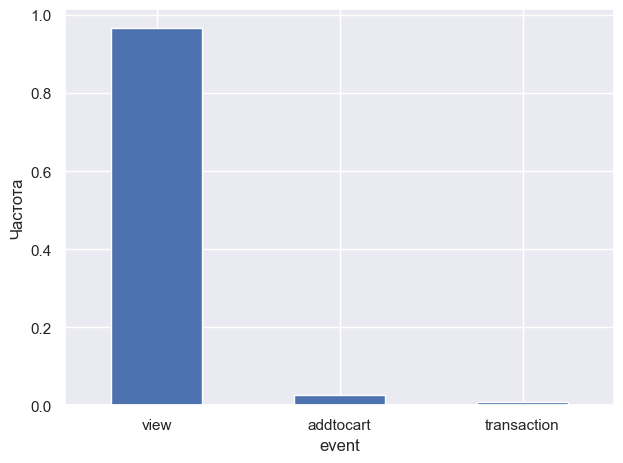

In [31]:
events.event \
    .value_counts(normalize=True) \
    .plot(kind="bar")
plt.xticks(rotation=0)
plt.ylabel("Частота")
plt.tight_layout()
plt.savefig(f"{ASSETS}/user_actions.png")
plt.show()

In [32]:
# транзакции составляют очень маленькую часть от всех событий
# не все добавления в корзину ведут к покупкам

In [33]:
events['transactionid'].notna().sum()

np.int64(22457)

In [34]:
events['transactionid'].nunique()

17672

In [35]:
events[events['transactionid'].notna()][
    events[events['transactionid'].notna()].duplicated(subset=["transactionid"])
].sort_values(by="transactionid")

,timestamp,visitorid,event,itemid,transactionid
1793308,1431978994534,288956,transaction,432742,12.0
77335,1433448499720,527277,transaction,397642,23.0
92102,1433448499642,527277,transaction,57548,23.0
80335,1433448499642,527277,transaction,93556,23.0
2537288,1437584753339,518659,transaction,272770,27.0
...,...,...,...,...,...
791365,1439345588928,530559,transaction,265920,17660.0
805249,1439345589053,530559,transaction,157743,17660.0
929833,1439949233505,795731,transaction,442610,17662.0
924918,1439924299698,465862,transaction,180349,17663.0


In [36]:
# transaktion id может содержать несколько товаров

In [37]:
print("Топ юзеров по числу покупок")
events \
    .groupby("visitorid") \
    .agg({"transactionid": "nunique"}) \
    .sort_values(by="transactionid", ascending=False) \
    .reset_index() \
    .head(10)

Топ юзеров по числу покупок


,visitorid,transactionid
0,1150086,502
1,152963,278
2,530559,221
3,684514,162
4,76757,155
5,861299,148
6,138131,137
7,247235,124
8,1297062,111
9,890980,104


In [38]:
print("Топ покупок")
events \
    .groupby("itemid") \
    .agg({"transactionid": "nunique"}) \
    .sort_values(by="transactionid", ascending=False) \
    .reset_index() \
    .head(10)

Топ покупок


,itemid,transactionid
0,461686,133
1,119736,96
2,213834,92
3,7943,46
4,312728,46
5,445351,45
6,48030,41
7,248455,38
8,420960,38
9,17478,37


### 2.3. item properties

In [39]:
item_props_1.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999999 entries, 0 to 10999998
Data columns (total 4 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   timestamp  int64 
 1   itemid     int64 
 2   property   object
 3   value      object
dtypes: int64(2), object(2)
memory usage: 1.5 GB


In [40]:
item_props_2.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9275903 entries, 0 to 9275902
Data columns (total 4 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   timestamp  int64 
 1   itemid     int64 
 2   property   object
 3   value      object
dtypes: int64(2), object(2)
memory usage: 1.3 GB


In [41]:
item_props_1.sample(10)

,timestamp,itemid,property,value
4898932,1431226800000,242374,764,1285872
7771478,1433041200000,311119,550,769062
3055364,1432436400000,138651,888,1126377
10575110,1435460400000,2514,888,433558
7362788,1439089200000,305237,available,0
7382005,1439694000000,255021,698,931348 630194
3912094,1433041200000,26526,790,n5280.000
2512207,1439694000000,351102,698,1040170 1242195
5273955,1436065200000,381882,790,n541440.000
3309501,1433041200000,381804,955,988697 581051


In [42]:
item_props_2.sample(10)

,timestamp,itemid,property,value
1715198,1441508400000,424309,888,793655 726612 268087 86628
6886829,1432436400000,106136,1004,1055803 n11640.000
8567649,1441508400000,215427,663,1297729 n156.000 606827
1076388,1435460400000,117545,544,992862 695898 798916
5696614,1431226800000,36129,364,1172556
1455062,1436670000000,316705,400,1297729 n720.000 1178208 n900.000 424566
8076423,1440298800000,10963,561,991263 1238769
3761393,1442113200000,419724,888,827388 547970 575391 424566 767591 639502 n12....
7431107,1433646000000,144700,400,n2220.000
18915,1431226800000,52609,888,150169 1037891 1101149 1017320 632432 923209 3...


item_properties.csv — таблица со свойствами товаров:
- timestamp — временная метка добавления свойства,
- itemid — идентификатор товара,
- property — свойство товара,
- value — значение свойства.

In [43]:
print("Уникальных itemid в item_props_1: ",item_props_1.itemid.nunique())
print("Уникальных itemid в item_props_2: ",item_props_2.itemid.nunique())

Уникальных itemid в item_props_1:  417053
Уникальных itemid в item_props_2:  417053


In [44]:
item_props_1.property.value_counts().head(10)

property
888           1629817
790            970800
available      817387
categoryid     426305
6              343207
283            323681
776            311654
678            261829
364            256340
202            242984
Name: count, dtype: int64

In [45]:
item_props_2.property.value_counts().head(10)

property
888           1370581
790            819716
available      686252
categoryid     361909
6              288264
283            273738
776            262566
364            220146
678            220137
202            205954
Name: count, dtype: int64

In [46]:
# Видим что есть признаки по доступности и категории товаров

In [47]:
category_props_1 = item_props_1.query("property == 'categoryid'")
print("Категорий в category_props_1:", category_props_1.shape)
category_props_2 = item_props_2.query("property == 'categoryid'")
print("Категорий в category_props_2:", category_props_2.shape)

Категорий в category_props_1: (426305, 4)
Категорий в category_props_2: (361909, 4)


In [48]:
# Создадим общую таблицу с инфорамцией о категориях
category_props = pd.concat([category_props_1, category_props_2])
category_props.shape

(788214, 4)

In [49]:
category_props.head(10)

,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
140,1432436400000,281245,categoryid,1277
151,1435460400000,35575,categoryid,1059
189,1437274800000,8313,categoryid,1147
197,1437879600000,55102,categoryid,47
213,1433041200000,397079,categoryid,619
237,1436670000000,265036,categoryid,1228
254,1437879600000,124459,categoryid,1277
310,1437879600000,350508,categoryid,546
325,1439089200000,221365,categoryid,1226


In [50]:
assert category_props.shape[0] == category_props[['itemid', 'value']].drop_duplicates().shape[0], 'В итоговой таблице есть дубли'

AssertionError: В итоговой таблице есть дубли

In [51]:
category_props.info()

<class 'pandas.core.frame.DataFrame'>
Index: 788214 entries, 0 to 9275879
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   timestamp  788214 non-null  int64 
 1   itemid     788214 non-null  int64 
 2   property   788214 non-null  object
 3   value      788214 non-null  object
dtypes: int64(2), object(2)
memory usage: 30.1+ MB


In [52]:
category_props["value"] = category_props["value"].astype("int64")

In [53]:
# Уберем дубли (оставим только самые свежие по времени знения) и сджойним с category_tree
category_props = category_props \
            .sort_values(by=["itemid", "timestamp"]) \
            .drop_duplicates(subset=["itemid"], keep="last") \
            .merge(category_tree, left_on="value", right_on="categoryid") \
            .drop(["timestamp", "property", "value"], axis=1)
category_props.head(10)

,itemid,categoryid,parentid
0,0,209,293.0
1,1,1114,113.0
2,2,1305,1214.0
3,3,1171,938.0
4,4,1038,1174.0
5,5,1061,1259.0
6,6,1091,573.0
7,7,512,362.0
8,8,173,788.0
9,10,1301,1034.0


In [54]:
# получилась удобнаятаблица с инфо о товарах и их категориях

In [55]:
category_props.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416921 entries, 0 to 416920
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   itemid      416921 non-null  int64  
 1   categoryid  416921 non-null  int64  
 2   parentid    416896 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 9.5 MB


In [56]:
category_props.isna().sum()

itemid         0
categoryid     0
parentid      25
dtype: int64

In [57]:
# еще осталось 25 товаров с неизвестной родительской категории

In [58]:
# Посмотрим на признак доступности товара

In [59]:
availability_props_1 = item_props_1.query("property == 'available'")
print("количество строк с инфо о доступности товара в availability_props_1: ", availability_props_1.shape[0])
availability_props_2 = item_props_2.query("property == 'available'")
print("количество строк с инфо о доступности товара в availability_props_2: ", availability_props_2.shape[0])

количество строк с инфо о доступности товара в availability_props_1:  817387
количество строк с инфо о доступности товара в availability_props_2:  686252


In [60]:
availability_props = pd.concat([availability_props_1, availability_props_2])
availability_props.shape

(1503639, 4)

In [61]:
availability_props["value"] = availability_props["value"].astype("int64")
availability_props = availability_props \
            .sort_values(by=["itemid", "timestamp"]) \
            .drop_duplicates(subset=["itemid"], keep="last") \
            .drop(["timestamp", "property"], axis=1)
availability_props.head(10)

,itemid,value
9066791,0,0
7699440,1,0
2122310,2,0
795922,3,0
725402,4,0
4224223,5,0
8612731,6,0
2012333,7,0
6601625,8,0
7535032,10,0


In [62]:
availability_props['value'].value_counts(dropna=False)

value
0    363043
1     54010
Name: count, dtype: int64

In [63]:
category_props = category_props.rename(
    columns={
        "itemid": "item_id",
        "categoryid": "category_id",
        "parentid": "parent_id",
    }
)
category_props.head()

,item_id,category_id,parent_id
0,0,209,293.0
1,1,1114,113.0
2,2,1305,1214.0
3,3,1171,938.0
4,4,1038,1174.0


In [64]:
availability_props = availability_props.rename(
    columns={
        "itemid": "item_id",
        "value": "available",
    }
)
availability_props.head()

,item_id,available
9066791,0,0
7699440,1,0
2122310,2,0
795922,3,0
725402,4,0


In [65]:
# попробуем посмотреть другие фичи

In [66]:
item_props_1[item_props_1['property'] == '888'].head(10)

,timestamp,itemid,property,value
1,1441508400000,206783,888,1116713 960601 n277.200
10,1439089200000,450113,888,1038400 45956 n504.000
17,1436670000000,319291,888,1292080
26,1435460400000,16615,888,150169 176547 824301 24474 293011 1240134
40,1433646000000,152892,888,599031
45,1435460400000,95237,888,883447 726612
48,1442113200000,372355,888,1051803 1227205 n712862568.000 992862 951748 6...
57,1434250800000,4454,888,1024724 220869
65,1432436400000,313836,888,n120.000 586893 1166722 237874 43137
75,1431226800000,53090,888,297660 1301543


In [67]:
# непонятные характеристики

In [68]:
item_props_1[item_props_1['property'] == '790']['value'].value_counts()

value
n0.000          10955
n8400.000        3876
n5760.000        2743
n9480.000        2692
n6240.000        2557
                ...  
n2180400.000        1
n78864.000          1
n114732.000         1
n22265.040          1
n25272.000          1
Name: count, Length: 25995, dtype: int64

In [69]:
# непонятные характеристики

In [70]:
item_props_1[item_props_1['property'] == '6']['value'].value_counts()

value
1115994                                24096
1152934 1238769                        19621
1263524                                14367
1252290 1319279 920988                 11406
452320 853231                           9399
                                       ...  
1264010 408257 1065616                     1
1296854 968890                             1
353870 434109 45241                        1
1322342 38028 150169 968890 1325686        1
457851 1222786 1133979 1338115             1
Name: count, Length: 4134, dtype: int64

In [71]:
# непонятные характеристики

In [72]:
item_props_1[item_props_1['property'] == '283']['value'].value_counts()

value
1319279 920988 828472                                                                                                                                                                                                                                                           1251
1319279 920988 639039                                                                                                                                                                                                                                                            846
61706 920988 828472                                                                                                                                                                                                                                                              799
61706 920988 639039                                                                                                                                                

In [73]:
# непонятные характеристики - какаято история

In [74]:
item_props_1[item_props_1['property'] == '776']

,timestamp,itemid,property,value
32,1432436400000,324117,776,168106
36,1441508400000,367159,776,1325415
62,1433646000000,136445,776,466048
106,1431831600000,322092,776,1017929
141,1431226800000,22474,776,39354
...,...,...,...,...
10999869,1433041200000,280477,776,723856
10999887,1431226800000,420001,776,120384
10999920,1440298800000,10793,776,637750
10999947,1431226800000,417455,776,1224743


In [75]:
item_props_1.property.value_counts().head(20)

property
888           1629817
790            970800
available      817387
categoryid     426305
6              343207
283            323681
776            311654
678            261829
364            256340
202            242984
839            226921
159            226502
917            226437
764            226242
112            226102
227            188209
698            157281
451            142388
663            131331
962            128976
Name: count, dtype: int64

In [76]:
# Перебирать все характеристики не будем, пока хватит доступности и того что мы сматчили итемсы с их группами

### 2.4. Сохраним артефакты этапа в Mlflow

In [77]:
RUN_NAME = "eda"
with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id
    mlflow.log_artifact(f"{ASSETS}/user_actions.png", "eda")

🏃 View run eda at: http://127.0.0.1:5000/#/experiments/1/runs/532788699b72478abe56fd0fec90de14
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


### 2.5. Выводы

- Не все категории могут быть частью родительской группы. По даным, 25 групп не имеют родителя.

- Действия пользователя - просмотр, добавление в корзину и покупка. Добавление в корзину и покупка занимают очень малую долю от всех действий пользователей. Идентификатор покупки может охватывать несколько айтемов. Покупка возможна только после добавления в корзину.

- Свойства айтемов представляют собой два набора данных с разнообразной информацией о различных своиствах и их значениях. Для дальнейшей работы мы вытянули связь между группой товара и его айтемайди, а также иснофрмацию о доступности товара. Остальные частотные свойства не получилось както правильно интерпретировать.

# 3. Обучение рекомендаций

На данном этапе мы должны подготовить несколько видов рекомендательных моделей:
- Офлайн рекомендации:
    - Персональные рекомендации
    - Топ самых популярных айтемов
- Онлайн рекомендации, основанные на похожести айтемов

### 3.1 Подготовка событий

In [78]:
# переименуем события
events = events.rename(
    columns={
        "visitorid": "user_id",
        "itemid": "item_id",
        "transactionid": "transaction_id",
    }
)
events.head()

,timestamp,user_id,event,item_id,transaction_id
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN


In [79]:
# оценим долю событий которую можно брать для юзеров

In [80]:
for trsh in [1, 2, 3, 5, 7, 10, 20, 30, 50, 100, 1000]:
    print(f"Для отметки {trsh} мы оставим {(events.groupby('user_id')['event'].count() >= trsh).sum() / events['user_id'].nunique()} юзеров")

Для отметки 1 мы оставим 1.0 юзеров
Для отметки 2 мы оставим 0.28845252134869775 юзеров
Для отметки 3 мы оставим 0.14210773099930377 юзеров
Для отметки 5 мы оставим 0.05798604697423947 юзеров
Для отметки 7 мы оставим 0.03159678313133179 юзеров
Для отметки 10 мы оставим 0.016511317296352607 юзеров
Для отметки 20 мы оставим 0.004696003069097316 юзеров
Для отметки 30 мы оставим 0.0022542235610054136 юзеров
Для отметки 50 мы оставим 0.0008994160189829352 юзеров
Для отметки 100 мы оставим 0.0002962531436934313 юзеров
Для отметки 1000 мы оставим 2.1313175805282825e-05 юзеров


In [81]:
# Удалим тех у кого меньше 100 событий:
user_events_count = events.groupby("user_id")["event"].count()
user_ids_to_remove = user_events_count[user_events_count < 100].index
user_ids_to_remove.shape

(1407163,)

In [82]:
# также посмотрим по айтемам

In [83]:
for trsh in [1, 2, 3, 5, 7, 10, 20, 30, 50, 100, 1000]:
    print(f"Для отметки {trsh} мы оставим {(events.groupby('item_id')['event'].count() >= trsh).sum() / events['user_id'].nunique()} айтемов")

Для отметки 1 мы оставим 0.16699654726551955 айтемов
Для отметки 2 мы оставим 0.11470182867048409 айтемов
Для отметки 3 мы оставим 0.08995794199974425 айтемов
Для отметки 5 мы оставим 0.06461302377129541 айтемов
Для отметки 7 мы оставим 0.0511075747026812 айтемов
Для отметки 10 мы оставим 0.03916509185978772 айтемов
Для отметки 20 мы оставим 0.021701786044132483 айтемов
Для отметки 30 мы оставим 0.014366501371147644 айтемов
Для отметки 50 мы оставим 0.007932764034726267 айтемов
Для отметки 100 мы оставим 0.0029987638358032935 айтемов
Для отметки 1000 мы оставим 2.5575810966339392e-05 айтемов


In [84]:
# Удалим тех айткмы у кого менее 60 событий:
item_events_count = events.groupby("item_id")["event"].count()
item_ids_to_remove = item_events_count[item_events_count < 250].index
item_ids_to_remove.shape

(234259,)

In [85]:
events = events[~events.user_id.isin(user_ids_to_remove)]
events = events[~events.item_id.isin(item_ids_to_remove)]
events.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21012 entries, 196 to 2755603
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   timestamp       21012 non-null  int64  
 1   user_id         21012 non-null  int64  
 2   event           21012 non-null  object 
 3   item_id         21012 non-null  int64  
 4   transaction_id  1222 non-null   float64
dtypes: float64(1), int64(3), object(1)
memory usage: 984.9+ KB


In [86]:
# посмотрим распределение

In [87]:
events.event.value_counts(0.1)

event
view           0.857510
addtocart      0.084333
transaction    0.058157
Name: proportion, dtype: float64

In [88]:
def get_date(timestamp):
    date = datetime.fromtimestamp(timestamp / 1000)
    return date.date()

In [89]:
events["date_event"] = events["timestamp"].apply(get_date)
events["date_event"] = pd.to_datetime(events["date_event"])
events.head(10)

,timestamp,user_id,event,item_id,transaction_id,date_event
196,1433193535886,820159,view,369447,NaN,2015-06-02
295,1433193493124,1317249,view,204070,NaN,2015-06-02
458,1433218757551,168685,addtocart,111530,NaN,2015-06-02
637,1433218636795,776534,view,20388,NaN,2015-06-02
648,1433218656883,776534,view,20388,NaN,2015-06-02
748,1433172520454,1172198,view,414460,NaN,2015-06-01
894,1433175895575,138131,addtocart,430292,NaN,2015-06-02
896,1433176296108,350566,view,379520,NaN,2015-06-02
1057,1433182122967,820159,view,305588,NaN,2015-06-02
1078,1433181873120,38015,view,304685,NaN,2015-06-02


In [90]:
min(events.date_event), max(events.date_event)

(Timestamp('2015-05-03 00:00:00'), Timestamp('2015-09-18 00:00:00'))

In [91]:
users_unique = events.user_id.nunique()
items_unique = events.item_id.nunique()

print("Число уникальных пользователей: ", users_unique)
print("Число уникальных товаров: ", items_unique)

Число уникальных пользователей:  355
Число уникальных товаров:  714


Придумаем функцию рейтинга:

- основа -  это частота по просмотрам домноженая на 0.01
- плюс частота добавлений в корзину домноженая на 0.39
- плюс частота покупок - домноженная на 0.6

In [92]:
events_view = events[events['event'] == 'view'].groupby('item_id')['timestamp'].count().reset_index().rename(columns={'timestamp': 'view_cnt'})

In [93]:
events_addcart = events[events['event'] == 'addtocart'].groupby('item_id')['timestamp'].count().reset_index().rename(columns={'timestamp': 'addcart_cnt'})

In [94]:
events_trans = events[events['event'] == 'transaction'].groupby('item_id')['timestamp'].count().reset_index().rename(columns={'timestamp': 'trans_cnt'})

In [95]:
items_raiting = events_view.merge(
    events_addcart, 
    how='left',
    on='item_id'
).merge(
    events_trans,
    how='left',
    on='item_id'
).fillna(0)

In [96]:
def get_rate(df):
    return df['view_cnt'] * 0.01 + df['addcart_cnt'] * 0.39 + df['trans_cnt'] * 0.6

In [97]:
items_raiting

,item_id,view_cnt,addcart_cnt,trans_cnt
0,546,90,13.0,9.0
1,829,30,7.0,3.0
2,869,29,6.0,5.0
3,2836,29,3.0,0.0
4,4001,23,5.0,4.0
...,...,...,...,...
709,465511,14,0.0,1.0
710,465522,29,6.0,5.0
711,466008,15,0.0,0.0
712,466109,19,4.0,2.0


In [98]:
items_raiting['rating'] = get_rate(items_raiting)

In [99]:
items_raiting

,item_id,view_cnt,addcart_cnt,trans_cnt,rating
0,546,90,13.0,9.0,11.37
1,829,30,7.0,3.0,4.83
2,869,29,6.0,5.0,5.63
3,2836,29,3.0,0.0,1.46
4,4001,23,5.0,4.0,4.58
...,...,...,...,...,...
709,465511,14,0.0,1.0,0.74
710,465522,29,6.0,5.0,5.63
711,466008,15,0.0,0.0,0.15
712,466109,19,4.0,2.0,2.95


In [100]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [101]:
items_raiting['rating'] = NormalizeData(items_raiting['rating'])

In [102]:
events = events.merge(items_raiting[['item_id', 'rating']], how='left', on='item_id')
events['rating'].fillna(0, inplace=True)

/var/folders/26/jzfnfwpd7zgcvfy170ph67w40000gn/T/ipykernel_82662/268285812.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  events['rating'].fillna(0, inplace=True)


In [103]:
events['rating'].isna().sum()

np.int64(0)

In [104]:
(events['rating'] == 0).sum()

np.int64(35)

In [105]:
# нужно сделать новые идентификаторы пользователей и товаров
user_encoder = LabelEncoder()
item_encoder = LabelEncoder()

user_encoder.fit(events["user_id"])
item_encoder.fit(events["item_id"])

events["user_id_encoded"] = user_encoder.transform(events["user_id"])
events["item_id_encoded"] = item_encoder.transform(events["item_id"])
events.head(10)

,timestamp,user_id,event,item_id,transaction_id,date_event,rating,user_id_encoded,item_id_encoded
0,1433193535886,820159,view,369447,NaN,2015-06-02,0.136826,212,551
1,1433193493124,1317249,view,204070,NaN,2015-06-02,0.002090,330,286
2,1433218757551,168685,addtocart,111530,NaN,2015-06-02,0.087780,46,163
3,1433218636795,776534,view,20388,NaN,2015-06-02,0.032325,200,25
4,1433218656883,776534,view,20388,NaN,2015-06-02,0.032325,200,25
5,1433172520454,1172198,view,414460,NaN,2015-06-01,0.054619,305,619
6,1433175895575,138131,addtocart,430292,NaN,2015-06-02,0.020343,38,642
7,1433176296108,350566,view,379520,NaN,2015-06-02,0.028424,92,566
8,1433182122967,820159,view,305588,NaN,2015-06-02,0.020621,212,446
9,1433181873120,38015,view,304685,NaN,2015-06-02,0.025777,9,443


In [106]:
# сохраним энкодеры
with open(f"{ASSETS}/user_encoder.pkl", "wb") as fd:
    joblib.dump(user_encoder, fd)

with open(f"{ASSETS}/item_encoder.pkl", "wb") as fd:
    joblib.dump(item_encoder, fd)

In [107]:
events = events[
    ["timestamp", "user_id", "item_id", "event", 
     "date_event", "user_id_encoded", 
     "item_id_encoded", "rating"]
]
events = events.reset_index(drop=True)
events.head(20)

,timestamp,user_id,item_id,event,date_event,user_id_encoded,item_id_encoded,rating
0,1433193535886,820159,369447,view,2015-06-02,212,551,0.136826
1,1433193493124,1317249,204070,view,2015-06-02,330,286,0.002090
2,1433218757551,168685,111530,addtocart,2015-06-02,46,163,0.087780
3,1433218636795,776534,20388,view,2015-06-02,200,25,0.032325
4,1433218656883,776534,20388,view,2015-06-02,200,25,0.032325
5,1433172520454,1172198,414460,view,2015-06-01,305,619,0.054619
6,1433175895575,138131,430292,addtocart,2015-06-02,38,642,0.020343
7,1433176296108,350566,379520,view,2015-06-02,92,566,0.028424
8,1433182122967,820159,305588,view,2015-06-02,212,446,0.020621
9,1433181873120,38015,304685,view,2015-06-02,9,443,0.025777


In [108]:
# сохраним данные
events.to_parquet(f"{ASSETS}/events.parquet")

### 3.2 Разделение данных

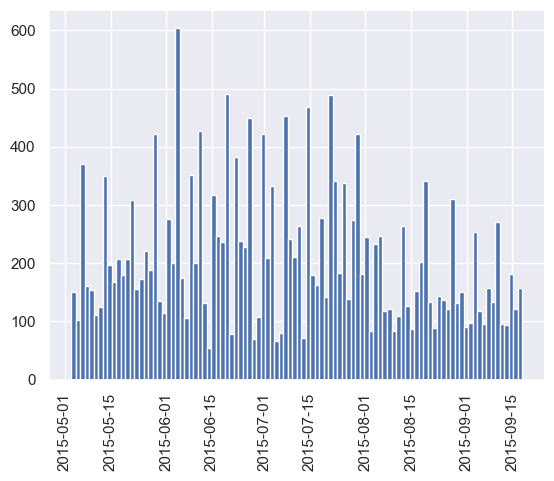

In [109]:
events['date_event'].hist(bins=100)
plt.xticks(rotation=90)
plt.show()

In [110]:
# Возьмем глобальную точку на уровне 2015-08-01
global_time_split = pd.to_datetime("2015-08-01")

filter_global_time = events["date_event"] < global_time_split
events_train = events[filter_global_time].copy()
events_test = events[~filter_global_time].copy()

print("Train число семплов :", events_train.shape[0])
print("Test  число семплов :", events_test.shape[0])

Train число семплов : 15518
Test  число семплов : 5494


In [111]:
# Проверим распределение событий в трейне и тесте

In [112]:
print(events_train.event.value_counts(0.1))
print(events_test.event.value_counts(0.1))

event
view           0.860678
addtocart      0.084160
transaction    0.055162
Name: proportion, dtype: float64
event
view           0.848562
addtocart      0.084820
transaction    0.066618
Name: proportion, dtype: float64


In [113]:
# посмотрим что у нас по пользователям

In [114]:
users_train = events_train["user_id"].drop_duplicates().tolist()
users_test = events_test["user_id"].drop_duplicates().tolist()

common_users = set(users_train) & set(users_test)
cold_users = (set(users_train) | set(users_test)) - set(users_train)

print("Число уникальных юзеров в train: ", len(users_train))
print("Число уникальных юзеров в test: ", len(users_test))
print("Число юзеров которые есть и в трейне и тесте: ", len(common_users))
print("Число холодных юзеров: ", len(cold_users))

Число уникальных юзеров в train:  310
Число уникальных юзеров в test:  149
Число юзеров которые есть и в трейне и тесте:  104
Число холодных юзеров:  45


### 3.3 Рекомендации на основе популярных айтемов 
можно давать рекомендации новым юзерам

In [115]:
TOP_N = 100

top_popular = events_train[events_train['event'] == 'addtocart']['item_id'] \
            .value_counts() \
            .head(TOP_N) \
            .reset_index() \
            .rename(columns={
                "count": "items_cnt"
            })

In [116]:
top_popular

,item_id,items_cnt
0,29196,32
1,312728,24
2,338427,20
3,409804,18
4,119736,18
...,...,...
95,325310,4
96,241555,4
97,78163,4
98,100282,4


In [117]:
top_popular["item_id_encoded"] = item_encoder.transform(top_popular["item_id"])

In [118]:
top_popular

,item_id,items_cnt,item_id_encoded
0,29196,32,39
1,312728,24,458
2,338427,20,489
3,409804,18,612
4,119736,18,179
...,...,...,...
95,325310,4,473
96,241555,4,344
97,78163,4,109
98,100282,4,149


In [119]:
top_popular = top_popular.reset_index().reset_index()
top_popular["level_0"] = top_popular["level_0"] + 1
top_popular = top_popular.rename(
    columns={
        "index": "rec_id",
        "level_0": "id",
    }
)

top_popular

,id,rec_id,item_id,items_cnt,item_id_encoded
0,1,0,29196,32,39
1,2,1,312728,24,458
2,3,2,338427,20,489
3,4,3,409804,18,612
4,5,4,119736,18,179
...,...,...,...,...,...
95,96,95,325310,4,473
96,97,96,241555,4,344
97,98,97,78163,4,109
98,99,98,100282,4,149


In [120]:
# Тут мы получили первые рекомендации которые сохраним локально и отправим в postgres.

In [121]:
top_popular.to_parquet(f"{POSTGRES_DATA}/top_popular.parquet")

### 3.4 Персональные рекомендации 

In [122]:
# Во первых нам нужно подготовить спарс матрицу, а затем обучим ALS модель

In [123]:
events_train.head()

,timestamp,user_id,item_id,event,date_event,user_id_encoded,item_id_encoded,rating
0,1433193535886,820159,369447,view,2015-06-02,212,551,0.136826
1,1433193493124,1317249,204070,view,2015-06-02,330,286,0.002090
2,1433218757551,168685,111530,addtocart,2015-06-02,46,163,0.087780
3,1433218636795,776534,20388,view,2015-06-02,200,25,0.032325
4,1433218656883,776534,20388,view,2015-06-02,200,25,0.032325


In [124]:
user_item_matrix_train = scipy.sparse.csr_matrix(
    (
    events_train["rating"],
    (events_train["user_id_encoded"], events_train["item_id_encoded"])
    ),
    dtype=np.int8
)
user_item_matrix_train

<355x714 sparse matrix of type '<class 'numpy.int8'>'
	with 6174 stored elements in Compressed Sparse Row format>

In [125]:
als_params = {
    "factors": 50,
    "iterations": 1000,
    "regularization": 0.01,
    "random_state": RANDOM_STATE,
}

als_model = AlternatingLeastSquares(**als_params)
als_model.fit(user_item_matrix_train)

/Users/andryousha/Projects/Python_projects/mle-pr-final/.pr_final/lib/python3.9/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 10 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


  0%|          | 0/1000 [00:00<?, ?it/s]

In [126]:
user_ids_encoded = range(len(user_encoder.classes_))

In [127]:
# рекомендации для всех юзеров
als_recommendations = als_model.recommend(
    userid=user_ids_encoded, 
    user_items=user_item_matrix_train[user_ids_encoded], 
    filter_already_liked_items=False, 
    N=100,
)

In [128]:
# превратим в удобный датафрейм

In [129]:
track_ids_encoded = als_recommendations[0]
als_scores = als_recommendations[1]

als_recommendations = pd.DataFrame({
    "user_id_encoded": user_ids_encoded,
    "item_id_encoded": track_ids_encoded.tolist(), 
    "score": als_scores.tolist(),
})
als_recommendations = als_recommendations.explode(["item_id_encoded", "score"], ignore_index=True)

als_recommendations["item_id_encoded"] = als_recommendations["item_id_encoded"].astype("int")
als_recommendations["score"] = als_recommendations["score"].astype("float")

als_recommendations["user_id"] = user_encoder.inverse_transform(als_recommendations["user_id_encoded"])
als_recommendations["item_id"] = item_encoder.inverse_transform(als_recommendations["item_id_encoded"])
als_recommendations = als_recommendations.drop(columns=["user_id_encoded", "item_id_encoded"])

als_recommendations = als_recommendations[["user_id", "item_id", "score"]]

In [132]:
(als_recommendations['score'] == 0).sum() / als_recommendations.shape[0]

np.float64(0.1267605633802817)

In [133]:
# уберем нулевые скоры
# als_recommendations = als_recommendations.query("score != 0")
als_recommendations

,user_id,item_id,score
0,1879,303833,2.581183e-19
1,1879,448220,2.580484e-19
2,1879,142466,2.309789e-19
3,1879,463663,2.274439e-19
4,1879,367956,2.229746e-19
...,...,...,...
35495,1403769,55925,1.846607e-20
35496,1403769,89688,1.834298e-20
35497,1403769,114866,1.793206e-20
35498,1403769,441852,1.708300e-20


In [134]:
# сохраним еще одни рекомендации

In [135]:
als_recommendations.to_parquet(f"{ASSETS}/personal_als.parquet")

### 3.4 Рекомендации на основе схожести айтемов
Для онлайн рекомендаций

In [136]:
train_item_ids_encoded = range(len(item_encoder.classes_))

similar_items = als_model.similar_items(train_item_ids_encoded, N=5)

In [137]:
# подготовим датафрейм

In [138]:
sim_item_item_ids_enc = similar_items[0]
sim_item_scores = similar_items[1]

similar_items = pd.DataFrame({
    "itemid_encoded": train_item_ids_encoded,
    "sim_itemid_encoded": sim_item_item_ids_enc.tolist(), 
    "score": sim_item_scores.tolist()})
similar_items = similar_items.explode(["sim_itemid_encoded", "score"], ignore_index=True)

similar_items["sim_itemid_encoded"] = similar_items["sim_itemid_encoded"].astype("int64")
similar_items["score"] = similar_items["score"].astype("float")

similar_items["itemid_1"] = item_encoder.inverse_transform(similar_items["itemid_encoded"])
similar_items["itemid_2"] = item_encoder.inverse_transform(similar_items["sim_itemid_encoded"])
similar_items = similar_items.drop(columns=["itemid_encoded", "sim_itemid_encoded"])

similar_items = similar_items.query("itemid_1 != itemid_2")

similar_items = similar_items[["itemid_1", "itemid_2", "score"]]
similar_items = similar_items.query("score != 0")
similar_items

,itemid_1,itemid_2,score
1,546,6605,0.770503
2,546,40864,0.770024
3,546,389814,0.763187
4,546,291877,0.754593
6,829,124583,0.710305
...,...,...,...
3564,466109,54875,0.790588
3566,466385,150547,0.671563
3567,466385,306289,0.598075
3568,466385,383715,0.571007


In [139]:
similar_items = similar_items.reset_index().reset_index()
similar_items["level_0"] = similar_items["level_0"] + 1
similar_items = similar_items.rename(
    columns={
        "index": "rec_id",
        "level_0": "id",
    }
)
similar_items

,id,rec_id,itemid_1,itemid_2,score
0,1,1,546,6605,0.770503
1,2,2,546,40864,0.770024
2,3,3,546,389814,0.763187
3,4,4,546,291877,0.754593
4,5,6,829,124583,0.710305
...,...,...,...,...,...
2771,2772,3564,466109,54875,0.790588
2772,2773,3566,466385,150547,0.671563
2773,2774,3567,466385,306289,0.598075
2774,2775,3568,466385,383715,0.571007


In [140]:
# сохраним для работы в Postgres

In [141]:
similar_items.to_parquet(f"{POSTGRES_DATA}/similar.parquet")

### 3.5 Логгирование объектов в MLFLOW

In [142]:
# сама модель ALS не является моделью, поэтому нужно написать класс для логирования ALS в качестве пользовательской модели MLFLOW

In [143]:
class ALSModel(mlflow.pyfunc.PythonModel):
    """Обертка для ALS модели"""

    def __init__(self, model, user_ids_encoded, filter_already_liked_items, N):
        """Инициализация модели"""
        super().__init__()
        self._model = model
        self.user_ids_encoded = user_ids_encoded
        self.filter_already_liked_items = filter_already_liked_items
        self.N = N
    
    def predict(self, context, model_input):
        """Генерация рекомендаций"""
        als_recommendations = self._model.recommend(
            userid=self.user_ids_encoded, 
            user_items=model_input[self.user_ids_encoded], 
            filter_already_liked_items=self.filter_already_liked_items, 
            N=self.N,
        )
        return als_recommendations

/Users/andryousha/Projects/Python_projects/mle-pr-final/.pr_final/lib/python3.9/site-packages/mlflow/pyfunc/utils/data_validation.py:186: UserWarning: Add type hints to the `predict` method to enable data validation and automatic signature inference during model logging. Check https://mlflow.org/docs/latest/model/python_model.html#type-hint-usage-in-pythonmodel for more details.
  color_warning(


In [144]:
als_model_for_mlflow = ALSModel(
    model=als_model,
    user_ids_encoded=user_ids_encoded,
    filter_already_liked_items=False,
    N=5,
)

In [145]:
als_model_for_mlflow

In [146]:
# теперь залоггируем

In [147]:
RUN_NAME = "recommendations_generation"
REGISTERED_MODEL_NAME = "als_model_train_v4"
with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    
    run_id = run.info.run_id
    
    mlflow.log_artifact(f"{ASSETS}/events.parquet", "data")
    
    mlflow.log_artifact(f"{ASSETS}/personal_als.parquet", "recommendations")
    mlflow.log_artifact(f"{POSTGRES_DATA}/top_popular.parquet", "recommendations")
    mlflow.log_artifact(f"{POSTGRES_DATA}/similar.parquet", "recommendations")

    mlflow.log_artifact(f"{ASSETS}/user_encoder.pkl", "encoders")
    mlflow.log_artifact(f"{ASSETS}/item_encoder.pkl", "encoders")
    
    mlflow.log_params(als_params)
    model_info = mlflow.pyfunc.log_model(
        registered_model_name=REGISTERED_MODEL_NAME,
        python_model=als_model_for_mlflow,
        pip_requirements = '../requirements.txt', 
        name='models',
    )

2025/07/19 20:41:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'als_model_train_v4' already exists. Creating a new version of this model...
2025/07/19 20:41:20 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: als_model_train_v4, version 2
Created version '2' of model 'als_model_train_v4'.


🏃 View run recommendations_generation at: http://127.0.0.1:5000/#/experiments/1/runs/588be19b7fea4e6d80a05f3d3d399129
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


In [148]:
# проверим работает ли модель

In [149]:
als_model_loaded = mlflow.pyfunc.load_model(
    model_uri=model_info.model_uri,
)

In [150]:
als_model_loaded.predict(user_item_matrix_train)

(array([[441, 671, 211, 705, 545],
        [  4,   3,   2,   1,   0],
        [671, 441, 249, 307, 196],
        ...,
        [  4,   3,   2,   1,   0],
        [179, 187, 534, 108, 218],
        [671, 441, 545, 307, 196]], dtype=int32),
 array([[2.5811830e-19, 2.5804840e-19, 2.3097892e-19, 2.2744388e-19,
         2.2297460e-19],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00],
        [2.5248603e-19, 1.5629765e-19, 1.4302925e-19, 1.3192284e-19,
         1.2185558e-19],
        ...,
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00],
        [1.2176547e-12, 4.5406973e-19, 3.9684264e-19, 3.8247206e-19,
         3.3409455e-19],
        [2.7105385e-19, 2.0721978e-19, 1.8505139e-19, 1.7080093e-19,
         1.6984810e-19]], dtype=float32))

In [151]:
# все ок

# 4. Обучение ранжирующей модели

### 4.1 Выбор трейн кандидатов

In [152]:
# Разделим выборку теста еще на две части

In [153]:
events_test.head()

,timestamp,user_id,item_id,event,date_event,user_id_encoded,item_id_encoded,rating
5707,1438454518049,1293358,456005,addtocart,2015-08-02,324,689,0.049324
5708,1438456382712,1098890,6605,view,2015-08-02,278,7,0.027309
5709,1438441059952,1015139,449489,view,2015-08-01,263,673,0.041661
5710,1438443451104,1150086,133814,view,2015-08-01,299,201,0.001811
5711,1438470121571,1150086,127537,view,2015-08-02,299,191,0.003483


In [154]:
split_date = pd.to_datetime("2015-09-01")

split_test_filter = events_test["date_event"] < split_date
events_test_1 = events_test[split_test_filter].copy()
events_test_2 = events_test[~split_test_filter].copy()

print(events_test_1.shape, events_test_2.shape)

(3628, 8) (1866, 8)


In [155]:
events_test_1.event.value_counts()

event
view           3046
addtocart       320
transaction     262
Name: count, dtype: int64

In [156]:
events_test_2.event.value_counts()

event
view           1616
addtocart       146
transaction     104
Name: count, dtype: int64

In [157]:
# разметим событие добаления в корзину и добавим в таргет

In [158]:
events_test_1["target"] = 0
events_test_1.loc[events_test_1["event"].isin(['addtocart', 'transaction']), "target"] = 1

In [159]:
events_test_1.sort_values(by=["item_id", "event"], ascending=[True, False]).drop_duplicates(subset=["user_id", "item_id"], keep="last")['target'].value_counts(dropna=False)

target
0    1356
1     297
Name: count, dtype: int64

In [160]:
# удалим лишние строки оставим только последние
events_test_1_wo_dubl = events_test_1.sort_values(
    by=["item_id", "event"], ascending=[True, False]
).drop_duplicates(
    subset=["user_id", "item_id"], keep="last"
)

In [161]:
candidates = als_recommendations.merge(
        events_test_1_wo_dubl[["user_id", "item_id", "target"]],
        on=["user_id", "item_id"],
        how="left",
        validate="many_to_one",
    )

In [162]:
candidates["target"] = candidates["target"].fillna(0).astype("int")

In [163]:
candidates.target.value_counts()

target
0    35443
1       57
Name: count, dtype: int64

Получили сильный перекос в балансе классов, модель als генерирует не особо хорошие рекомендации, определяет небольшое кол-во целевых действий (добавление в корзину). Возможно это свзано с тем, чо я придумал не достаточно хороший рейтинг, также у нас очень мало класса 1 в данных. Возможно стило сделать таргет через мой рейтинг.

In [164]:
# попробуем немного улучшить ситуацию - для каждого негативного таргета возьмем рандомно только 10 записей.

In [165]:
candidates_for_train = pd.concat([
    candidates.query("target == 1"),
    candidates.query("target == 0") \
        .groupby("user_id") \
        .apply(lambda x: x.sample(10, random_state=RANDOM_STATE))
])

/var/folders/26/jzfnfwpd7zgcvfy170ph67w40000gn/T/ipykernel_82662/552112257.py:3: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  candidates.query("target == 0") \


In [166]:
candidates_for_train = candidates_for_train.reset_index(drop=True)
display(candidates_for_train.head())
display(candidates_for_train.info())

,user_id,item_id,score,target
0,17676,63543,0.0,1
1,17676,869,0.0,1
2,17676,546,0.0,1
3,152963,43267,0.0,1
4,152963,37029,0.0,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3607 entries, 0 to 3606
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  3607 non-null   int64  
 1   item_id  3607 non-null   int64  
 2   score    3607 non-null   float64
 3   target   3607 non-null   int64  
dtypes: float64(1), int64(3)
memory usage: 112.8 KB


None

In [168]:
candidates_for_train.target.value_counts(normalize=True)

target
0    0.984197
1    0.015803
Name: proportion, dtype: float64

In [169]:
# Изменим candidates_for_train чтобы загрузить в Postgres

In [170]:
candidates_train = candidates_for_train.reset_index()
candidates_train = candidates_train.rename(columns={
    "index": "rec_id",
    "score": "als_score",
})
candidates_train["id"] = candidates_train.reset_index()["index"] + 1
candidates_train = candidates_train[["id", "rec_id", "user_id", "item_id", "als_score", "target"]]
candidates_train

,id,rec_id,user_id,item_id,als_score,target
0,1,0,17676,63543,0.000000e+00,1
1,2,1,17676,869,0.000000e+00,1
2,3,2,17676,546,0.000000e+00,1
3,4,3,152963,43267,0.000000e+00,1
4,5,4,152963,37029,0.000000e+00,1
...,...,...,...,...,...,...
3602,3603,3602,1403769,448220,2.710539e-19,0
3603,3604,3603,1403769,463663,1.695048e-19,0
3604,3605,3604,1403769,23762,5.542643e-20,0
3605,3606,3605,1403769,460188,2.828095e-20,0


### 4.2 Добавим фичи

In [171]:
# category_id, parent_id, available

In [172]:
candidates_train = candidates_train.merge(
    category_props[["item_id", "category_id", "parent_id"]],
    on="item_id",
    how="left",
    validate="many_to_one"
)

candidates_train = candidates_train.dropna()
candidates_train["category_id"] = candidates_train["category_id"].astype("int64")
candidates_train["parent_id"] = candidates_train["parent_id"].astype("int64")

In [173]:
candidates_train = candidates_train.merge(
    availability_props[["item_id", "available"]],
    on="item_id",
    how="left",
    validate="many_to_one",
)

In [174]:
candidates_train.head()

,id,rec_id,user_id,item_id,als_score,target,category_id,parent_id,available
0,1,0,17676,63543,0.0,1,589,1308,1
1,2,1,17676,869,0.0,1,1650,1426,0
2,3,2,17676,546,0.0,1,1349,121,0
3,4,3,152963,43267,0.0,1,1623,1066,1
4,5,4,152963,37029,0.0,1,1483,561,0


In [175]:
candidates_train["id"] = np.arange(1, candidates_train.shape[0] + 1)
candidates_train

,id,rec_id,user_id,item_id,als_score,target,category_id,parent_id,available
0,1,0,17676,63543,0.000000e+00,1,589,1308,1
1,2,1,17676,869,0.000000e+00,1,1650,1426,0
2,3,2,17676,546,0.000000e+00,1,1349,121,0
3,4,3,152963,43267,0.000000e+00,1,1623,1066,1
4,5,4,152963,37029,0.000000e+00,1,1483,561,0
...,...,...,...,...,...,...,...,...,...
3556,3557,3602,1403769,448220,2.710539e-19,0,175,1492,1
3557,3558,3603,1403769,463663,1.695048e-19,0,1263,1637,1
3558,3559,3604,1403769,23762,5.542643e-20,0,84,1308,0
3559,3560,3605,1403769,460188,2.828095e-20,0,1051,955,1


In [176]:
candidates_train.isna().sum()

id             0
rec_id         0
user_id        0
item_id        0
als_score      0
target         0
category_id    0
parent_id      0
available      0
dtype: int64

In [178]:
candidates_train.to_parquet(f"{POSTGRES_DATA}/candidates_train.parquet")

### 4.3 Создадим кандидатов для ражирования

In [180]:
inference_data = pd.concat([events_train, events_test_1_wo_dubl])
inference_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17171 entries, 0 to 7615
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   timestamp        17171 non-null  int64         
 1   user_id          17171 non-null  int64         
 2   item_id          17171 non-null  int64         
 3   event            17171 non-null  object        
 4   date_event       17171 non-null  datetime64[ns]
 5   user_id_encoded  17171 non-null  int64         
 6   item_id_encoded  17171 non-null  int64         
 7   rating           17171 non-null  float64       
 8   target           1653 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(5), object(1)
memory usage: 1.3+ MB


In [181]:
# снова обучим ALS

In [182]:
user_item_matrix_inference = scipy.sparse.csr_matrix(
    (
    inference_data["rating"],
    (inference_data["user_id_encoded"], inference_data["item_id_encoded"])
    ),
    dtype=np.int8
)
user_item_matrix_inference

<355x714 sparse matrix of type '<class 'numpy.int8'>'
	with 7595 stored elements in Compressed Sparse Row format>

In [183]:
als_model_inference = AlternatingLeastSquares(**als_params)
als_model_inference.fit(user_item_matrix_inference)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [184]:
user_ids_encoded = range(len(user_encoder.classes_))

als_recommendations_inference = als_model_inference.recommend(
    user_ids_encoded, 
    user_item_matrix_inference[user_ids_encoded], 
    filter_already_liked_items=False, 
    N=100,
)

In [185]:
item_ids_encoded = als_recommendations_inference[0]
als_scores = als_recommendations_inference[1]

als_recommendations_inference = pd.DataFrame({
    "user_id_encoded": user_ids_encoded,
    "item_id_encoded": item_ids_encoded.tolist(), 
    "score": als_scores.tolist(),
})
als_recommendations_inference = als_recommendations_inference.explode(
    ["item_id_encoded", "score"], ignore_index=True
)

als_recommendations_inference["item_id_encoded"] = als_recommendations_inference["item_id_encoded"].astype("int")
als_recommendations_inference["score"] = als_recommendations_inference["score"].astype("float")

als_recommendations_inference["user_id"] = user_encoder.inverse_transform(
    als_recommendations_inference["user_id_encoded"]
)
als_recommendations_inference["item_id"] = item_encoder.inverse_transform(
    als_recommendations_inference["item_id_encoded"]
)
als_recommendations_inference = als_recommendations_inference.drop(
    columns=["user_id_encoded", "item_id_encoded"]
)

als_recommendations_inference = als_recommendations_inference[["user_id", "item_id", "score"]]
als_recommendations_inference = als_recommendations_inference.query("score != 0")
als_recommendations_inference.head(10)

,user_id,item_id,score
0,1879,119736,9.872077e-13
1,1879,350399,1.993567e-20
2,1879,829,1.990749e-20
3,1879,323194,1.715107e-20
4,1879,289633,1.712453e-20
5,1879,425726,1.650482e-20
6,1879,444593,1.539325e-20
7,1879,234493,1.524505e-20
8,1879,453235,1.457608e-20
9,1879,436004,1.446925e-20


In [187]:
als_recommendations_inference.to_parquet(f"{ASSETS}/personal_als_inference.parquet")

In [188]:
# выберем только кандидатов из events_test_2

In [189]:
candidates_to_rank = als_recommendations_inference[
    als_recommendations_inference.user_id.isin(events_test_2.user_id.drop_duplicates())
]
candidates_to_rank.head()

,user_id,item_id,score
100,2194,456792,1.039188e-20
101,2194,829,9.458311e-21
102,2194,139770,9.181698e-21
103,2194,101094,8.551724e-21
104,2194,392074,8.386984e-21


In [190]:
candidates_inference = candidates_to_rank.reset_index()
candidates_inference = candidates_inference.rename(columns={
    "index": "rec_id",
    "score": "als_score",
})
candidates_inference["id"] = candidates_inference.reset_index()["index"] + 1
candidates_inference = candidates_inference[["id", "rec_id", "user_id", "item_id", "als_score"]]
candidates_inference

,id,rec_id,user_id,item_id,als_score
0,1,100,2194,456792,1.039188e-20
1,2,101,2194,829,9.458311e-21
2,3,102,2194,139770,9.181698e-21
3,4,103,2194,101094,8.551724e-21
4,5,104,2194,392074,8.386984e-21
...,...,...,...,...,...
6795,6796,35495,1403769,298056,1.990580e-20
6796,6797,35496,1403769,456005,1.987911e-20
6797,6798,35497,1403769,368060,1.979903e-20
6798,6799,35498,1403769,48030,1.961440e-20


### 4.4 Добавим фичи к кандидатам для ранжирования

In [192]:
candidates_inference = candidates_inference.merge(
    category_props[["item_id", "category_id", "parent_id"]],
    on="item_id",
    how="left",
    validate="many_to_one"
)

candidates_inference = candidates_inference.dropna()
candidates_inference

,id,rec_id,user_id,item_id,als_score,category_id,parent_id
0,1,100,2194,456792,1.039188e-20,819.0,798.0
1,2,101,2194,829,9.458311e-21,707.0,561.0
2,3,102,2194,139770,9.181698e-21,1325.0,1684.0
3,4,103,2194,101094,8.551724e-21,1341.0,480.0
4,5,104,2194,392074,8.386984e-21,959.0,1095.0
...,...,...,...,...,...,...,...
6795,6796,35495,1403769,298056,1.990580e-20,1051.0,955.0
6796,6797,35496,1403769,456005,1.987911e-20,1051.0,955.0
6797,6798,35497,1403769,368060,1.979903e-20,491.0,679.0
6798,6799,35498,1403769,48030,1.961440e-20,1219.0,121.0


In [193]:
candidates_inference["category_id"] = candidates_inference["category_id"].astype("int64")
candidates_inference["parent_id"] = candidates_inference["parent_id"].astype("int64")
candidates_inference = candidates_inference.merge(
    availability_props[["item_id", "available"]],
    on="item_id",
    how="left",
)

In [194]:
candidates_inference["id"] = np.arange(1, candidates_inference.shape[0] + 1)
candidates_inference

,id,rec_id,user_id,item_id,als_score,category_id,parent_id,available
0,1,100,2194,456792,1.039188e-20,819,798,0
1,2,101,2194,829,9.458311e-21,707,561,0
2,3,102,2194,139770,9.181698e-21,1325,1684,1
3,4,103,2194,101094,8.551724e-21,1341,480,0
4,5,104,2194,392074,8.386984e-21,959,1095,0
...,...,...,...,...,...,...,...,...
6723,6724,35495,1403769,298056,1.990580e-20,1051,955,1
6724,6725,35496,1403769,456005,1.987911e-20,1051,955,1
6725,6726,35497,1403769,368060,1.979903e-20,491,679,1
6726,6727,35498,1403769,48030,1.961440e-20,1219,121,0


In [195]:
candidates_inference.to_parquet(f"{POSTGRES_DATA}/candidates_inference.parquet")

### 4.4 Логгируем артефакты в MLFLOW

In [196]:
als_model_mlflow_inference = ALSModel(
    model=als_model_inference,
    user_ids_encoded=user_ids_encoded,
    filter_already_liked_items=False,
    N=5,
)

In [198]:
RUN_NAME = "candidates_generation"
REGISTERED_MODEL_NAME = "als_model_inference"
with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    
    run_id = run.info.run_id
    
    mlflow.log_artifact(f"{ASSETS}/personal_als_inference.parquet", "recommendations")

    mlflow.log_artifact(f"{POSTGRES_DATA}/candidates_train.parquet", "candidates")
    mlflow.log_artifact(f"{POSTGRES_DATA}/candidates_inference.parquet", "candidates")
    
    # Logging ALS model and its params
    mlflow.log_params(als_params)
    model_info = mlflow.pyfunc.log_model(
        registered_model_name=REGISTERED_MODEL_NAME,
        python_model=als_model_mlflow_inference,
        pip_requirements = '../requirements.txt', 
        name='models',
    )

2025/07/19 20:54:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'als_model_inference' already exists. Creating a new version of this model...
2025/07/19 20:54:59 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: als_model_inference, version 2
Created version '2' of model 'als_model_inference'.


🏃 View run candidates_generation at: http://127.0.0.1:5000/#/experiments/1/runs/812712ee3bc04f1e8d41db216b530c09
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


In [199]:
# проверка

In [200]:
als_model_loaded = mlflow.pyfunc.load_model(
    model_uri=model_info.model_uri,
)

In [201]:
als_model_loaded.predict(user_item_matrix_inference)

(array([[179, 513,   1, 471, 419],
        [690,   1, 209, 150, 593],
        [179, 298, 235, 641, 514],
        ...,
        [561, 690, 598, 607, 209],
        [179, 209,  99, 561, 619],
        [161, 357, 494,  53, 514]], dtype=int32),
 array([[9.87207711e-13, 1.99356667e-20, 1.99074892e-20, 1.71510714e-20,
         1.71245273e-20],
        [1.03918773e-20, 9.45831109e-21, 9.18169834e-21, 8.55172437e-21,
         8.38698376e-21],
        [7.74076170e-14, 1.29980181e-20, 9.79815065e-21, 9.70913422e-21,
         9.38398277e-21],
        ...,
        [9.95999855e-21, 9.71454240e-21, 9.64627011e-21, 8.98815504e-21,
         8.85188996e-21],
        [9.02940916e-12, 1.26414701e-20, 1.21637087e-20, 1.12911495e-20,
         1.03328066e-20],
        [8.21575236e-20, 7.06518807e-20, 6.98517063e-20, 6.88558907e-20,
         6.67956552e-20]], dtype=float32))

# 5. Обучение ранжирующей модели

In [202]:
# Обучим модель Catboost c 4 фичами als_score, available, category_id, parent_id

In [203]:
features = ["als_score", "category_id", "parent_id", "available"]
cat_features = ["category_id", "parent_id"]
target = ["target"]

In [207]:
catboost_params = {
    "iterations": 6000,
    "verbose": 200,
    "loss_function": "Logloss",
    "auto_class_weights": "Balanced",
    "random_seed": RANDOM_STATE,
}

In [208]:
train_data = Pool(
    data=candidates_train[features],
    label=candidates_train[target],
    cat_features=cat_features
)

model = CatBoostClassifier(**catboost_params)

model.fit(train_data)

Learning rate set to 0.003427
0:	learn: 0.6902230	total: 6.6ms	remaining: 39.6s
200:	learn: 0.5197959	total: 326ms	remaining: 9.42s
400:	learn: 0.4500572	total: 625ms	remaining: 8.73s
600:	learn: 0.4082602	total: 938ms	remaining: 8.43s
800:	learn: 0.3797966	total: 1.51s	remaining: 9.78s
1000:	learn: 0.3575837	total: 2.09s	remaining: 10.4s
1200:	learn: 0.3387186	total: 2.44s	remaining: 9.73s
1400:	learn: 0.3222245	total: 2.72s	remaining: 8.92s
1600:	learn: 0.3080479	total: 3.01s	remaining: 8.28s
1800:	learn: 0.2933708	total: 3.3s	remaining: 7.7s
2000:	learn: 0.2820346	total: 3.59s	remaining: 7.17s
2200:	learn: 0.2693864	total: 3.87s	remaining: 6.68s
2400:	learn: 0.2554894	total: 4.17s	remaining: 6.25s
2600:	learn: 0.2363007	total: 4.49s	remaining: 5.86s
2800:	learn: 0.2128010	total: 4.83s	remaining: 5.51s
3000:	learn: 0.1888611	total: 5.2s	remaining: 5.2s
3200:	learn: 0.1665668	total: 5.57s	remaining: 4.87s
3400:	learn: 0.1490380	total: 5.93s	remaining: 4.53s
3600:	learn: 0.1345317	tota

In [209]:
inf_data = Pool(data=candidates_inference[features], cat_features=cat_features)
predictions = model.predict_proba(inf_data)
candidates_inference["cb_score"] = predictions[:, 1]

# Сортировка
candidates_inference_ranked = candidates_inference.sort_values(
    by=["user_id", "cb_score"], ascending=[True, False]
)

# Ранжирование
candidates_inference_ranked["rank"] = candidates_inference_ranked.groupby("user_id").cumcount() + 1

candidates_inference_ranked["id"] = np.arange(1, candidates_inference_ranked.shape[0] + 1)
candidates_inference_ranked = candidates_inference_ranked.reset_index(drop=True)
candidates_inference_ranked

,id,rec_id,user_id,item_id,als_score,category_id,parent_id,available,cb_score,rank
0,1,112,2194,395435,6.797959e-21,707,561,1,0.697945,1
1,2,111,2194,234493,6.835821e-21,342,500,0,0.383374,2
2,3,108,2194,328696,8.044012e-21,1051,955,1,0.303567,3
3,4,122,2194,78163,6.287348e-21,342,500,1,0.276831,4
4,5,113,2194,181202,6.708043e-21,1051,955,1,0.252655,5
...,...,...,...,...,...,...,...,...,...,...
6723,6724,35448,1403769,144704,3.130475e-20,242,1531,0,0.000316,96
6724,6725,35402,1403769,339808,6.985171e-20,1322,252,0,0.000158,97
6725,6726,35428,1403769,446522,3.924149e-20,471,1368,0,0.000037,98
6726,6727,35426,1403769,185535,4.033300e-20,486,25,0,0.000020,99


In [210]:
# посмотрим на фичи

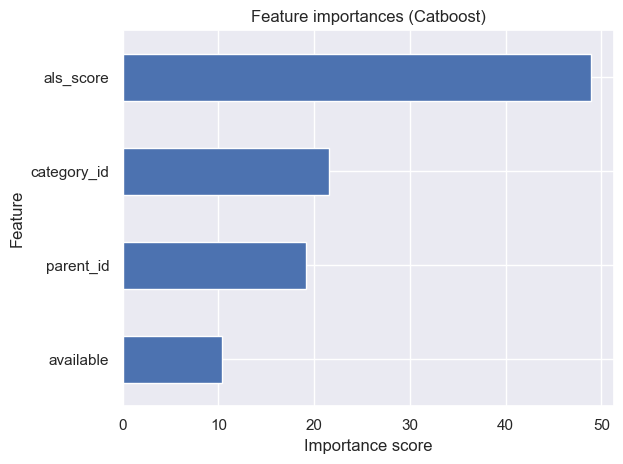

In [211]:
fi = pd.Series(
    model.feature_importances_,
    index=features,
    name="fi_final_recs",
).sort_values()

fi.plot(kind="barh")
plt.title("Feature importances (Catboost)")
plt.ylabel("Feature")
plt.xlabel("Importance score")
plt.tight_layout()
plt.savefig(f"{ASSETS}/feature_importances.png")
plt.show()

### 5.1 Оценивание метрик

In [212]:
def process_events_recs_for_binary_metrics(events_train, events_test, recs, top_k=None):
    """Labels <user_id, item_id> pairs for common users with features:
    - gt => ground truth
    - pr => prediction
    top_k => using top-k recommendations for computation
    """
    
    events_test["gt"] = True
    common_users = set(events_test["user_id"]) & set(recs["user_id"])
    
    events_for_common_users = events_test[events_test["user_id"].isin(common_users)].copy()
    recs_for_common_users = recs[recs["user_id"].isin(common_users)].copy()

    recs_for_common_users = recs_for_common_users.sort_values(["user_id", "score"], ascending=[True, False])

    events_for_common_users = events_for_common_users[events_for_common_users["item_id"].isin(
        events_train["item_id"].unique()
    )
    ]

    if top_k is not None:
        recs_for_common_users = recs_for_common_users.groupby("user_id").head(top_k)
    
    events_recs_common = events_for_common_users[["user_id", "item_id", "gt"]].merge(
        recs_for_common_users[["user_id", "item_id", "score"]], 
        on=["user_id", "item_id"], 
        how="outer",
    )

    events_recs_common["gt"] = events_recs_common["gt"].fillna(False)
    events_recs_common["pr"] = ~events_recs_common["score"].isnull()
    
    events_recs_common["tp"] = events_recs_common["gt"] & events_recs_common["pr"]
    events_recs_common["fp"] = ~events_recs_common["gt"] & events_recs_common["pr"]
    events_recs_common["fn"] = events_recs_common["gt"] & ~events_recs_common["pr"]

    return events_recs_common

In [213]:
def compute_cls_metrics(events_recs_for_binary_metric):
    """Computes precision and recall."""
    
    groupper = events_recs_for_binary_metric.groupby("user_id")

    # Computing precision
    precision = groupper["tp"].sum()/(groupper["tp"].sum()+groupper["fp"].sum())
    precision = precision.fillna(0).mean()
    
    # Computing recall
    recall = groupper["tp"].sum()/(groupper["tp"].sum()+groupper["fn"].sum())
    recall = recall.fillna(0).mean()

    return precision, recall

In [214]:
events_recs_for_binary_metric = process_events_recs_for_binary_metrics(
    inference_data,
    events_test_2,
    candidates_inference_ranked.rename(columns={"cb_score": "score"}),
    top_k=10,
)

precision_at_10_personal, recall_at_10_personal = compute_cls_metrics(events_recs_for_binary_metric)

print(f"Precision@10 = {precision_at_10_personal:.5f} ({precision_at_10_personal:.3%})")
print(f"Recall@10 = {recall_at_10_personal:.5f} ({recall_at_10_personal:.3%})")

Precision@10 = 0.04492 (4.492%)
Recall@10 = 0.01499 (1.499%)


/var/folders/26/jzfnfwpd7zgcvfy170ph67w40000gn/T/ipykernel_82662/2116620511.py:30: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  events_recs_common["gt"] = events_recs_common["gt"].fillna(False)


In [215]:
recommendation_metrics = {
    "precision_at_10": precision_at_10_personal,
    "recall_at_10": recall_at_10_personal
}
recommendation_metrics

{'precision_at_10': np.float64(0.044919786096256686),
 'recall_at_10': np.float64(0.014992025257993494)}

In [216]:
candidates_inference_ranked.to_parquet(f"{ASSETS}/personal_recommendations.parquet")

In [217]:
model.save_model(f"{POSTGRES_DATA}/catboost_model.cbm")

### 5.2 Логгирование в MLFLOW

In [218]:
RUN_NAME = "recommendations_ranking"
REGISTERED_MODEL_NAME = "cb_ranking_model"
with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    
    run_id = run.info.run_id
    mlflow.log_params(catboost_params)
    mlflow.log_metrics(recommendation_metrics)

    mlflow.log_artifact(f"{ASSETS}/personal_recommendations.parquet", "recommendations")
    mlflow.log_artifact(f"{ASSETS}/feature_importances.png", "cb_model")

    model_info = mlflow.catboost.log_model( 
            registered_model_name=REGISTERED_MODEL_NAME,
            cb_model=model,
            await_registration_for=60,
            artifact_path='models',
            pip_requirements="../requirements.txt",
    )

2025/07/19 21:03:00 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/19 21:03:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'cb_ranking_model'.
2025/07/19 21:03:23 INFO mlflow.store.model_registry.abstract_store: Waiting up to 60 seconds for model version to finish creation. Model name: cb_ranking_model, version 1
Created version '1' of model 'cb_ranking_model'.


🏃 View run recommendations_ranking at: http://127.0.0.1:5000/#/experiments/1/runs/ed3b7ef64df444b69e43d219c67f8f2b
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


### 5.3 Попробуем потюнить гиперпараметры

In [219]:
catboost_params = {
    "iterations": 1000,
    "learning_rate": 0.01,
    "depth": 4,
    "verbose": 200,
    "loss_function": "Logloss",
    "auto_class_weights": "Balanced",
    "random_seed": RANDOM_STATE,
}

In [220]:
train_data = Pool(
    data=candidates_train[features],
    label=candidates_train[target],
    cat_features=cat_features
)

model = CatBoostClassifier(**catboost_params)

model.fit(train_data)

0:	learn: 0.6843952	total: 4.6ms	remaining: 4.59s
200:	learn: 0.4671933	total: 295ms	remaining: 1.17s
400:	learn: 0.4092358	total: 556ms	remaining: 830ms
600:	learn: 0.3712252	total: 825ms	remaining: 548ms
800:	learn: 0.3280356	total: 1.1s	remaining: 273ms
999:	learn: 0.2684231	total: 1.39s	remaining: 0us


In [221]:
inf_data = Pool(data=candidates_inference[features], cat_features=cat_features)
predictions = model.predict_proba(inf_data)
candidates_inference["cb_score"] = predictions[:, 1]

# Сортировка
candidates_inference_ranked = candidates_inference.sort_values(
    by=["user_id", "cb_score"], ascending=[True, False]
)

# Ранжирование
candidates_inference_ranked["rank"] = candidates_inference_ranked.groupby("user_id").cumcount() + 1

candidates_inference_ranked["id"] = np.arange(1, candidates_inference_ranked.shape[0] + 1)
candidates_inference_ranked = candidates_inference_ranked.reset_index(drop=True)
candidates_inference_ranked

,id,rec_id,user_id,item_id,als_score,category_id,parent_id,available,cb_score,rank
0,1,133,2194,446934,5.213431e-21,35,20,1,0.710461,1
1,2,111,2194,234493,6.835821e-21,342,500,0,0.671544,2
2,3,122,2194,78163,6.287348e-21,342,500,1,0.664732,3
3,4,197,2194,400946,3.357855e-21,1273,125,1,0.649883,4
4,5,165,2194,132683,4.136347e-21,421,1424,1,0.647578,5
...,...,...,...,...,...,...,...,...,...,...
6723,6724,35448,1403769,144704,3.130475e-20,242,1531,0,0.015851,96
6724,6725,35402,1403769,339808,6.985171e-20,1322,252,0,0.009938,97
6725,6726,35428,1403769,446522,3.924149e-20,471,1368,0,0.002669,98
6726,6727,35426,1403769,185535,4.033300e-20,486,25,0,0.002494,99


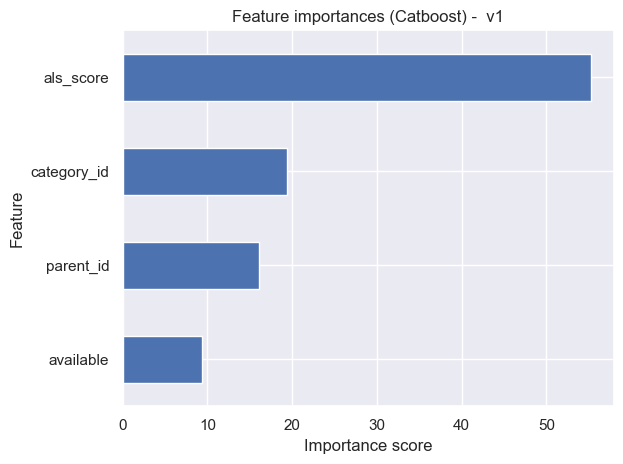

In [223]:
fi = pd.Series(
    model.feature_importances_,
    index=features,
    name="fi_final_recs",
).sort_values()

fi.plot(kind="barh")
plt.title("Feature importances (Catboost) -  v1")
plt.ylabel("Feature")
plt.xlabel("Importance score")
plt.tight_layout()
plt.savefig(f"{ASSETS}/feature_importances_2.png")
plt.show()

In [224]:
events_recs_for_binary_metric = process_events_recs_for_binary_metrics(
    inference_data,
    events_test_2,
    candidates_inference_ranked.rename(columns={"cb_score": "score"}),
    top_k=10,
)

precision_at_10_personal, recall_at_10_personal = compute_cls_metrics(events_recs_for_binary_metric)

print(f"Precision@10 = {precision_at_10_personal:.5f} ({precision_at_10_personal:.3%})")
print(f"Recall@10 = {recall_at_10_personal:.5f} ({recall_at_10_personal:.3%})")

Precision@10 = 0.05053 (5.053%)
Recall@10 = 0.01656 (1.656%)


/var/folders/26/jzfnfwpd7zgcvfy170ph67w40000gn/T/ipykernel_82662/2116620511.py:30: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  events_recs_common["gt"] = events_recs_common["gt"].fillna(False)


In [225]:
recommendation_metrics = {
    "precision_at_10": precision_at_10_personal,
    "recall_at_10": recall_at_10_personal
}
recommendation_metrics

{'precision_at_10': np.float64(0.05052814832226597),
 'recall_at_10': np.float64(0.016555165729678835)}

In [227]:
candidates_inference_ranked.to_parquet(f"{ASSETS}/personal_recommendations_2.parquet")

In [228]:
RUN_NAME = "recommendations_ranking_v1"
REGISTERED_MODEL_NAME = "cb_ranking_model"
with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    
    run_id = run.info.run_id
    mlflow.log_params(catboost_params)
    mlflow.log_metrics(recommendation_metrics)

    mlflow.log_artifact(f"{ASSETS}/personal_recommendations_2.parquet", "recommendations")
    mlflow.log_artifact(f"{ASSETS}/feature_importances_2.png", "cb_model")

    model_info = mlflow.catboost.log_model( 
            registered_model_name=REGISTERED_MODEL_NAME,
            cb_model=model,
            await_registration_for=60,
            artifact_path='models',
            pip_requirements="../requirements.txt",
    )

2025/07/19 21:06:32 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/19 21:06:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'cb_ranking_model' already exists. Creating a new version of this model...
2025/07/19 21:06:45 INFO mlflow.store.model_registry.abstract_store: Waiting up to 60 seconds for model version to finish creation. Model name: cb_ranking_model, version 2
Created version '2' of model 'cb_ranking_model'.


🏃 View run recommendations_ranking_v1 at: http://127.0.0.1:5000/#/experiments/1/runs/ea2c9f7803374ae59a7901046889044a
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


### 5.4 Попробуем потюнить гиперпараметры 2

In [330]:
catboost_params = {
    "iterations": 900,
    "learning_rate": 0.01,
    "depth": 4,
    "verbose": 200,
    "loss_function": "Logloss",
    "auto_class_weights": "Balanced",
    "random_seed": RANDOM_STATE,
}

In [331]:
train_data = Pool(
    data=candidates_train[features],
    label=candidates_train[target],
    cat_features=cat_features
)

model = CatBoostClassifier(**catboost_params)

model.fit(train_data)

0:	learn: 0.6843952	total: 8.93ms	remaining: 8.03s
200:	learn: 0.4671933	total: 307ms	remaining: 1.07s
400:	learn: 0.4092358	total: 568ms	remaining: 706ms
600:	learn: 0.3712252	total: 829ms	remaining: 412ms
800:	learn: 0.3280356	total: 1.09s	remaining: 135ms
899:	learn: 0.3002297	total: 1.23s	remaining: 0us


In [332]:
inf_data = Pool(data=candidates_inference[features], cat_features=cat_features)
predictions = model.predict_proba(inf_data)
candidates_inference["cb_score"] = predictions[:, 1]

candidates_inference_ranked = candidates_inference.sort_values(
    by=["user_id", "cb_score"], ascending=[True, False]
)

candidates_inference_ranked["rank"] = candidates_inference_ranked.groupby("user_id").cumcount() + 1

candidates_inference_ranked["id"] = np.arange(1, candidates_inference_ranked.shape[0] + 1)
candidates_inference_ranked = candidates_inference_ranked.reset_index(drop=True)
candidates_inference_ranked

,id,rec_id,user_id,item_id,als_score,category_id,parent_id,available,cb_score,rank
0,1,133,2194,446934,5.213431e-21,35,20,1,0.784774,1
1,2,165,2194,132683,4.136347e-21,421,1424,1,0.739531,2
2,3,146,2194,188698,4.609898e-21,1679,893,1,0.731675,3
3,4,197,2194,400946,3.357855e-21,1273,125,1,0.728852,4
4,5,143,2194,330647,4.728920e-21,1148,1696,1,0.716085,5
...,...,...,...,...,...,...,...,...,...,...
6723,6724,35448,1403769,144704,3.130475e-20,242,1531,0,0.020579,96
6724,6725,35402,1403769,339808,6.985171e-20,1322,252,0,0.015386,97
6725,6726,35428,1403769,446522,3.924149e-20,471,1368,0,0.004868,98
6726,6727,35426,1403769,185535,4.033300e-20,486,25,0,0.004447,99


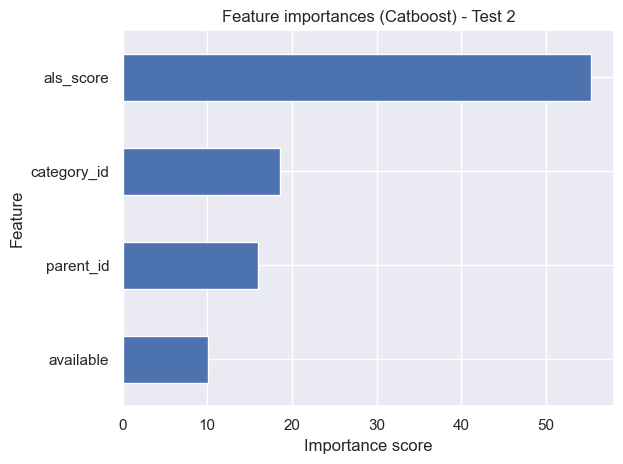

In [333]:
fi = pd.Series(
    model.feature_importances_,
    index=features,
    name="fi_final_recs",
).sort_values()

fi.plot(kind="barh")
plt.title("Feature importances (Catboost) - Test 2")
plt.ylabel("Feature")
plt.xlabel("Importance score")
plt.tight_layout()
plt.savefig(f"{ASSETS}/feature_importances_3.png")
plt.show()

In [334]:
events_recs_for_binary_metric = process_events_recs_for_binary_metrics(
    inference_data,
    events_test_2,
    candidates_inference_ranked.rename(columns={"cb_score": "score"}),
    top_k=10,
)

precision_at_10_personal, recall_at_10_personal = compute_cls_metrics(events_recs_for_binary_metric)

print(f"Precision@10 = {precision_at_10_personal:.5f} ({precision_at_10_personal:.3%})")
print(f"Recall@10 = {recall_at_10_personal:.5f} ({recall_at_10_personal:.3%})")

Precision@10 = 0.05200 (5.200%)
Recall@10 = 0.01667 (1.667%)


/var/folders/26/jzfnfwpd7zgcvfy170ph67w40000gn/T/ipykernel_82662/2116620511.py:30: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  events_recs_common["gt"] = events_recs_common["gt"].fillna(False)


In [335]:
recommendation_metrics = {
    "precision_at_10": precision_at_10_personal,
    "recall_at_10": recall_at_10_personal
}
recommendation_metrics

{'precision_at_10': np.float64(0.051998736557560085),
 'recall_at_10': np.float64(0.016670960078914592)}

In [337]:
candidates_inference_ranked.to_parquet(f"{ASSETS}/personal_recommendations_3.parquet")

In [338]:
UN_NAME = "recommendations_ranking_v2"
REGISTERED_MODEL_NAME = "cb_ranking_model"
with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    
    run_id = run.info.run_id
    mlflow.log_params(catboost_params)
    mlflow.log_metrics(recommendation_metrics)

    mlflow.log_artifact(f"{ASSETS}/personal_recommendations_3.parquet", "recommendations")
    mlflow.log_artifact(f"{ASSETS}/feature_importances_3.png", "cb_model")

    model_info = mlflow.catboost.log_model( 
            registered_model_name=REGISTERED_MODEL_NAME,
            cb_model=model,
            await_registration_for=60,
            artifact_path='models',
            pip_requirements="../requirements.txt",
    )

2025/07/19 21:18:22 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/19 21:18:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'cb_ranking_model' already exists. Creating a new version of this model...
2025/07/19 21:18:34 INFO mlflow.store.model_registry.abstract_store: Waiting up to 60 seconds for model version to finish creation. Model name: cb_ranking_model, version 3
Created version '3' of model 'cb_ranking_model'.


🏃 View run recommendations_ranking_v1 at: http://127.0.0.1:5000/#/experiments/1/runs/d292d9e48a5842f8916cbc8047ae0afd
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


### 5.4 Выбор лучшей модели

In [339]:
best_cb_model = mlflow.catboost.load_model(
    model_uri=model_info.model_uri
)

In [341]:
best_cb_model.get_params()

{'depth': 4,
 'random_seed': 123,
 'auto_class_weights': 'Balanced',
 'loss_function': 'Logloss',
 'learning_rate': 0.01,
 'iterations': 900,
 'verbose': 200}

In [342]:
best_cb_model.is_fitted()

True

In [343]:
best_cb_model.predict(inf_data)

array([0, 0, 1, ..., 0, 0, 0])

In [344]:
best_cb_model.save_model(f"{POSTGRES_DATA}/catboost_model.cbm")